In [2]:
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from random import randint 

from sklearn import tree
%matplotlib inline

from pandas.plotting import scatter_matrix

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.utils import shuffle


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor






In [5]:
# read in 2017 and 2018 songs
# songs_2018 = pd.read_csv('data/songs_2018.csv')
# songs_2017 = pd.read_csv('data/songs_2017.csv')

# songs_df = songs_2018.append(songs_2017, ignore_index=True)

# songs_df.head()

songs_df = pd.read_csv('data/songs_all_decade_clean.csv')

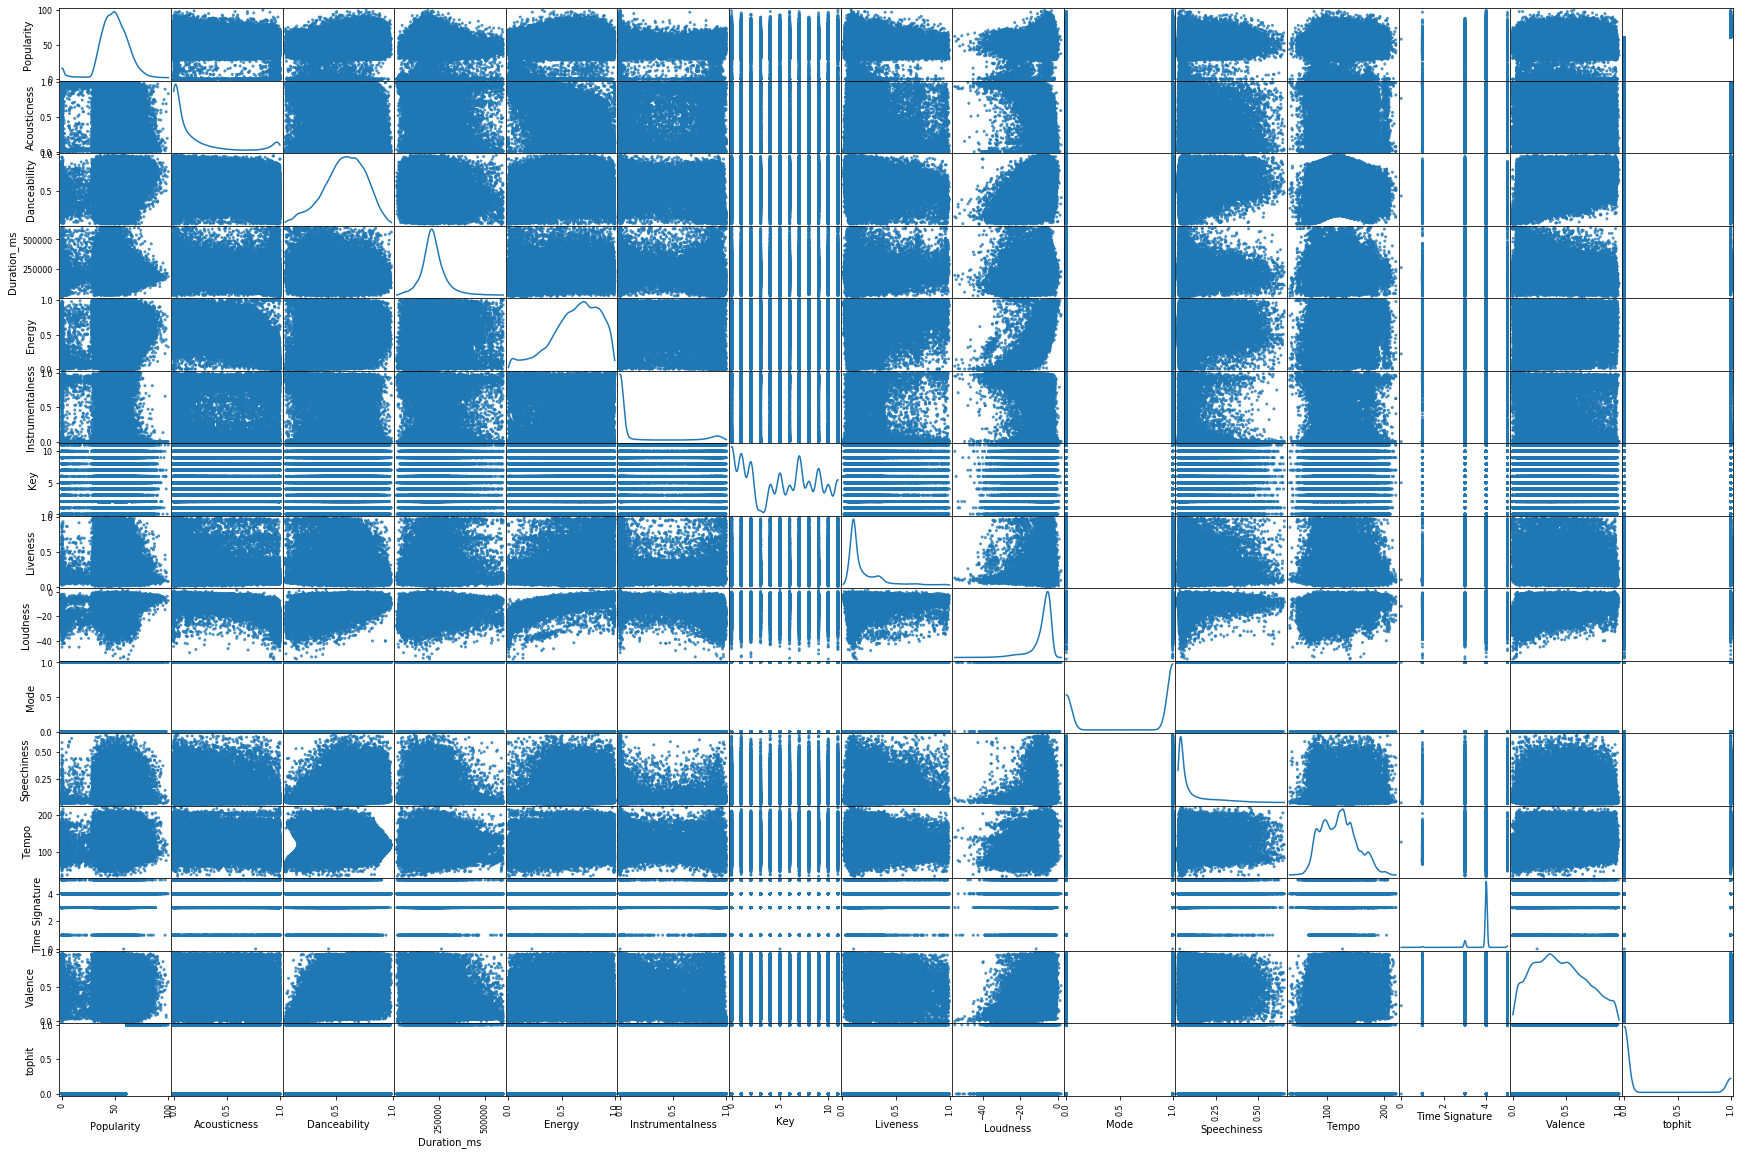

In [25]:
# scatter matrix

scatter_matrix(songs_df, alpha=0.8, figsize=(30, 20), diagonal='kde');




# CLASSIFICATION

In [6]:
# create new binary response variable 'tophit'
# classify as top hit if popularity > 60 (about halfway split)
songs_df['tophit'] = np.where(songs_df['Popularity'] > 60, 1, 0)



In [7]:
# prepare for modeling
songs_df_clean = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID', 'Popularity'])

X_train, X_test, y_train, y_test = train_test_split(songs_df_clean.loc[:, songs_df_clean.columns != 'tophit'], 
                                                    songs_df_clean.tophit, test_size = 0.2, 
                                                    random_state = 100, stratify = songs_df_clean.tophit)



In [8]:
# fit cross-validated single decision tree
depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, depths):
    cvmeans = {}
    cvstds = {}
    train_scores = {}
    for i in depths:
        model = DecisionTreeClassifier(max_depth = i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)
        # get training set scores
        train_scores[i] = accuracy_score(y_train, y_pred)
        # get cross-validation scores
        score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5, n_jobs = -1)
        cvmeans[i] = score.mean()
        cvstds[i] = score.std()
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths)

In [9]:
# report best tree depth from cross-validation
best_depth = sorted(cvmeans, key = cvmeans.get, reverse = True)[0]
print('Best depth:', best_depth)

# refit on best tree depth, then report classification accuracies
best_model = DecisionTreeClassifier(max_depth = best_depth)
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
best_cv_tree_train_score = accuracy_score(y_train, y_train_pred)
print('Classification accuracy on training set:', best_cv_tree_train_score)

y_test_pred = best_model.predict(X_test)
best_cv_tree_test_score = accuracy_score(y_test, y_test_pred)
print('Classification accuracy on test set:', best_cv_tree_test_score)

Best depth: 1
Classification accuracy on training set: 0.8256708496252276
Classification accuracy on test set: 0.8256450793292304


### BAGGING

In [10]:
# def bagger(n_trees, tree_depth, X_train, y_train, X_test, random_seed=0) -> (pd.DataFrame, pd.DataFrame, list):
#     """A function that takes as 
    
#     Inputs:
#       n_trees
#       tree_depth 
#       X_train
#       y_train
#       X_test
#       a random_seed (default =0)
    
#     Returns:
#       bagging_train dataframe 
#       bagging_test dataframe 
#       bagging_models every trained model for each bootstrap 
#     """
#     # your code here
#     #n_depths = len(tree_depth)
#     np.random.seed(random_seed)
#     bagging_train = np.zeros((X_train.shape[0], n_trees))
#     bagging_test = np.zeros((X_test.shape[0], n_trees))

#     bagging_models = []

#     for i in range(n_trees):
#         bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
#         fitted_model = DecisionTreeClassifier(max_depth=tree_depth).fit(bootstrapped_X, bootstrapped_y)
#         bagging_models.append(fitted_model)

#         bagging_train[:,i] = fitted_model.predict(X_train)
#         bagging_test[:,i] = fitted_model.predict(X_test)
    
#     return  pd.DataFrame(bagging_train[:,:], columns=[f"model{x}" for x in range(n_trees)]) \
#         , pd.DataFrame(bagging_test[:,:], columns=[f"model{x}" for x in range(n_trees)]) \
#         , bagging_models
     

In [11]:
n_trees = 55 
tree_depth = 10 #choose greater than ideal to overfit

# bagging_train_df, bagging_test_df, bagging_models = bagger(n_trees, tree_depth, X_train, y_train, X_test, random_seed= 0)
# display(bagging_train_df.head())
# display(bagging_test_df.head())

In [12]:

# bagging_train_predictions = np.mean(bagging_train_df.iloc[:,:], axis=1) > .5
# bagging_test_predictions = np.mean(bagging_test_df.iloc[:,:], axis=1) > .5
# bagging_accuracy_train = np.mean(bagging_train_predictions == np.array(y_train))
# bagging_accuracy_test = np.mean(bagging_test_predictions == np.array(y_test))

# print('# Trees:', n_trees)
# print('Depth:', tree_depth)
# print('Classification accuracy on training set:', bagging_accuracy_train)
# print('Classification accuracy on test set:', bagging_accuracy_test)



In [13]:
# using bagging classifier
fitted_bag = BaggingClassifier(n_estimators=n_trees, random_state=0).fit(X_train,y_train)
bag_train_score = fitted_bag.score(X_train, y_train)
bag_test_score = fitted_bag.score(X_test, y_test)

print('# Trees:', n_trees)
print('Depth:', tree_depth)
print('Classification accuracy on training set:', bag_train_score)
print('Classification accuracy on test set:', bag_test_score)



# Trees: 55
Depth: 10
Classification accuracy on training set: 0.9931538754711122
Classification accuracy on test set: 0.8274518660719327


### RANDOM FOREST

In [14]:
fitted_rf = RandomForestClassifier(n_estimators=n_trees, max_features='sqrt', max_depth=tree_depth).fit(X_train,y_train)
random_forest_train_score = fitted_rf.score(X_train, y_train)
random_forest_test_score = fitted_rf.score(X_test, y_test)

print('# Trees:', n_trees)
print('Depth:', tree_depth)
print('Classification accuracy on training set:', random_forest_train_score)
print('Classification accuracy on test set:', random_forest_test_score)



# Trees: 55
Depth: 10
Classification accuracy on training set: 0.8279152492130486
Classification accuracy on test set: 0.8259838518434871


# BOOSTING

In [15]:
# clfs = {}
# train_scores = {}
# test_scores = {}
# for depth in (1,2,3,4):
#     fitted_ada = AdaBoostClassifier(
#         base_estimator=DecisionTreeClassifier(max_depth=depth),
#         n_estimators=800,
#         learning_rate=.05).fit(X_train, y_train)
#     train_scores[depth] = list(fitted_ada.staged_score(X_train, y_train))
#     test_scores[depth] = list(fitted_ada.staged_score(X_test, y_test))
#     clfs[depth] = fitted_ada
    

In [16]:
# fig, axs = plt.subplots(1, 4, figsize=(20,10), sharey=True)
# for ax, depth in zip(axs, (1,2,3,4)):
#     ax.plot(train_scores[depth], label='train')
#     ax.plot(test_scores[depth], label='test')
#     ax.set(xlabel='Iteration', ylabel='Accuracy', title=f"max_depth={depth}")
#     ax.legend()
# plt.suptitle("Accuracy of AdaBoost as Training Progresses");

In [17]:
best_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
        n_estimators=225,
        learning_rate=.05).fit(X_train, y_train)
best_ada_train_score = best_ada.score(X_train, y_train)
best_ada_test_score = best_ada.score(X_test, y_test)



In [18]:
print('Max Depth:', 2)
print('# Estimators:', 225)
print('Classification accuracy on training set:', best_ada_train_score)
print('Classification accuracy on test set:', best_ada_test_score)


Max Depth: 2
# Estimators: 225
Classification accuracy on training set: 0.8256849653459057
Classification accuracy on test set: 0.8256450793292304


### LOGIT

In [19]:
logit = LogisticRegressionCV( solver='liblinear', penalty='l1', cv=5)
logit.fit(X_train, y_train)

log_y_train_pred = logit.predict(X_train) 
log_y_test_pred = logit.predict(X_test)

log_train_score = accuracy_score(y_train, log_y_train_pred)
log_test_score = accuracy_score(y_test, log_y_test_pred)

print('Penalty: LASSO')
print('Classification accuracy on training set:', log_train_score)
print('Classification accuracy on test set:', log_test_score)


Penalty: LASSO
Classification accuracy on training set: 0.8256708496252276
Classification accuracy on test set: 0.8256450793292304


# REGRESSION

In [20]:
# prepare for modeling
songs_df_clean2 = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID', 'tophit'])

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(songs_df_clean2.loc[:, songs_df_clean.columns != 'Popularity'], 
                                                    songs_df_clean2.Popularity, test_size = 0.2, 
                                                    random_state = 100)



### SINGLE TREE

In [21]:
tree_reg = DecisionTreeRegressor(criterion='mse', splitter='best').fit(X_train_2, y_train_2)

tree_reg_train_score = tree_reg.score(X_train_2, y_train_2)
print('R^2 on training set:', tree_reg_train_score)


tree_reg_test_score = tree_reg.score(X_test_2, y_test_2)
print('R^2 on test set:', tree_reg_test_score)



R^2 on training set: 1.0
R^2 on test set: 0.999999026549029


### BAGGING

In [22]:
bag_reg = BaggingRegressor(n_estimators=10, random_state=0).fit(X_train_2, y_train_2)

bag_reg_train_score = bag_reg.score(X_train_2, y_train_2)
print('R^2 on training set:', bag_reg_train_score)

bag_reg_test_score = bag_reg.score(X_test_2, y_test_2)
print('R^2 on test set:', bag_reg_test_score)


R^2 on training set: 0.9999995174952405
R^2 on test set: 0.9999991271389627


### RANDOM FOREST

In [23]:
rf_reg = RandomForestRegressor(n_estimators=100, criterion='mse').fit(X_train_2, y_train_2)

rf_reg_train_score = rf_reg.score(X_train_2, y_train_2)
print('R^2 on training set:', rf_reg_train_score)

rf_reg_test_score = rf_reg.score(X_test_2, y_test_2)
print('R^2 on test set:', rf_reg_test_score)




R^2 on training set: 0.9999998259524915
R^2 on test set: 0.9999992377878897


In [24]:
boost_reg = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100).fit(X_train_2, y_train_2)

boost_reg_train_score = boost_reg.score(X_train_2, y_train_2)
print('R^2 on training set:', boost_reg_train_score)

boost_reg_test_score = boost_reg.score(X_test_2, y_test_2)
print('R^2 on test set:', boost_reg_test_score)



R^2 on training set: 0.9999973358743461
R^2 on test set: 0.999996189269374


In [26]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np

In [27]:
cid = '304f47a7973c446fa4cc490eaec6d061'
secret = 'f70927ac3cf14606b2aa54d4217ccf35'

client_credentials_manager = SpotifyClientCredentials(client_id = cid, client_secret = secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [45]:

sp.search(q = 'year:2019', type = 'track', limit = 50)['tracks']['items'][0]['album']['release_date']


'2019-09-06'

In [46]:

artist_name, track_name, track_id, popularity, release_date = [], [], [], [], []
for i in range(0, 10000, 50):
    track_results = sp.search(q = 'year:2019', type = 'track', limit = 50, offset = i)
    audio_features = sp.audio_features(track_id[i : i + 50])
    for i, t in enumerate(track_results['tracks']['items']):
        print(t['artists'][0]['name'])
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])
        release_date.append(t['album']['release_date'])

Post Malone
Travis Scott
Arizona Zervas
Juice WRLD
Billie Eilish
Selena Gomez
blackbear
DaBaby
Maroon 5
YNW Melly
Lewis Capaldi
The Weeknd
NLE Choppa
Lizzo
Dan + Shay
Lil Tecca
Tones and I
DaBaby
Billie Eilish
Post Malone
Mustard
Drake
Dua Lipa
Post Malone
Kanye West
DaBaby
Young Thug
The Weeknd
Harry Styles
Lil Baby
Post Malone
YoungBoy Never Broke Again
Lil Mosey
SHAED
Sam Smith
Chris Brown
J. Cole
Halsey
Lil Tjay
Post Malone
Chance the Rapper
24kGoldn
Polo G
Selena Gomez
Y2K
Bad Bunny
Billie Eilish
Post Malone
21 Savage
Lizzo
Ellie Goulding
Camila Cabello
Lil Tecca
Internet Money
Lil Nas X
Ed Sheeran
Post Malone
Ant Saunders
Roddy Ricch
Lil Nas X
Tyler, The Creator
Ariana Grande
Lil Uzi Vert
Marshmello
Bad Bunny
Taylor Swift
Diplo
Ed Sheeran
J Balvin
Khalid
Taylor Swift
YoungBoy Never Broke Again
Lil Tecca
Lil Nas X
Post Malone
Young Thug
Post Malone
Quality Control
NLE Choppa
Taylor Swift
Niall Horan
Bazzi
Zedd
Ariana Grande
Lil Tecca
Harry Styles
Mustard
Post Malone
Mustard
The Bl

Rex Orange County
Kevin Gates
Farruko
Fat Joe
YoungBoy Never Broke Again
Alan Walker
Luke Combs
Rick Ross
iann dior
NF
iann dior
Chris Janson
Kelly Clarkson
The Chainsmokers
Avicii
Young Dolph
Rex Orange County
Dimelo Flow
Taylor Swift
Michael Bublé
Michael Bublé
Luis Fonsi
The Chainsmokers
Future
Dean Lewis
Bryce Vine
Lil Tecca
French Montana
5 Seconds of Summer
NF
Johnny Utah
Shoreline Mafia
Lizzo
French Montana
Brooks & Dunn
Zack Fox
Ruel
Willie Jones
Yo Gotti
Natanael Cano
Dalex
Taylor Swift
Junior H
Flo Milli
Kevin Gates
NLE Choppa
YBN Cordae
Charlie Puth
Dexys Midnight Runners
Joyner Lucas
Gabrielle Aplin
YoungBoy Never Broke Again
Lil Dicky
Rex Orange County
Lizzo
R3HAB
j-hope
Gesaffelstein
Kelsea Ballerini
J Balvin
Tyler Childers
Adriel Favela
The Chainsmokers
Daniel Caesar
AJ Mitchell
TOMORROW X TOGETHER
Dean Lewis
Oliver Tree
Polo G
Summer Walker
Melanie Martinez
Tory Lanez
Ariana Grande
Trippie Redd
Conan Gray
Bryant Myers
The Chainsmokers
Skye
Sech
Melanie Martinez
Zac Brow

iann dior
Will Smith
Marshmello
James TW
The Game
Chance the Rapper
Lewis Capaldi
Manuel Turizo
Fabolous
H.E.R.
Chelsea Cutler
Moon Laika
The Game
Lil Baby
Bastille
Avicii
Mau y Ricky
Fuerza Regida
The Black Keys
Myke Towers
Hobo Johnson
Conan Gray
Daya
bbno$
Rex Orange County
Marshmello
Shoreline Mafia
SiR
Jonas Brothers
Beyoncé
Kacey Musgraves
Pola Ris
Championxiii
BTS
Clairo
Calvin Harris
ITZY
Ed Sheeran
NoCap
The Lumineers
Hillsong UNITED
Lil Peep
Echo River
FLETCHER
Gucci Mane
Alex Couture
Gabby Barrett
BROCKHAMPTON
Granular
Kevin Gates
Skrillex
Matt Maeson
Herencia de Patrones
Arlette Leduc
Kevin Gates
Freya Ridings
Swae Lee
Los Hijos De Garcia
Kristen Bell
Lil Peep
Christian Nodal
A Day To Remember
Ali Gatie
Tyga
Blueface
Waterparks
The Game
Ruel
ILLENIUM
The Game
Opus Monik
The Lumineers
Rod Wave
Smino
AJR
Joyner Lucas
Missy Elliott
Aries
The Outdoor Library
Social House
Young M.A
James Bay
Ruel
iann dior
LiSA
Upchurch
Payton Smith
Lil Durk
Ruth B.
Ari Lennox
Kevin Gates
Maisie

Bastille
Pentatonix
Trouble
Junior H
Jai Wolf
Irizarry Barraza
Alejandro Fernandez
Oh Wonder
Fat Joe
Steven Universe
Badflower
Grimes
Sarah Spring
Bastille
Gunna
Offset
Kota the Friend
Ryan Hurd
EXO
FISHER
SOMI
Steven Goldmund
Bethel Music
Peter Kuli
Mindful Behaviour
Summer Walker
EARTHGANG
3ohBlack
2 Chainz
Jonas Blue
Gryffin
DDG
Jonas Brothers
Dame D.O.L.L.A
Wiz Khalifa
Beck
Mabel
Fall Out Boy
Hozier
G-Eazy
Bastille
Lenin Ramírez
JTres
City Girls
Mr Pillow
Bastille
Young Dolph
COIN
Yonder Dale
Omar Apollo
A$AP Ferg
Calma
Jack Stauber's Micropop
The Rolling Stones
Václav Slezák
The Rolling Stones
Jaden
The Rolling Stones
Tank
Christian Nodal
Bastille
Vince Staples
BigKlit
Cody Simpson
Bastille
YSN Flow
iann dior
Billy Eichner
Bastille
Dreamscaper
Bastille
Luke Combs
Love Falk
Bastille
Bastille
Bastille
Pathos Humano
Clifford Solum
Bastille
Bastille
Witt Lowry
Bastille
Bastille
Jeremy Camp
Matter and Energy
Surfaces
Lizzo
Green Day
Knowmadic
ATEEZ
Hoodie Allen
The Game
The Game
The Ga

Lil Keed
Danny Ocean
Antoine Minot
Summer Walker
BROCKHAMPTON
Zach Williams
Gunna
Travis Denning
John Legend
Maik Kuefer
Tyler Childers
Jordan Clarke
A Great Big World
Ali Gatie
The Holiday Horns
G-Eazy
MercyMe
London On Da Track
Ed Sheeran
Flipp Dinero
Marca MP
EDEN
Kevin Gates
Tyler Childers
Sufi Ellman
Marca MP
G Herbo
Lalo Ebratt
Burna Boy
Mr Eazi
Sabrina Claudio
Céline Dion
Verzache
Hillsong Worship
Grupo Firme
Michael Bublé
MyKey
TOKYO’S REVENGE
Crumb
Ghostemane
Shoreline Mafia
El Fantasma
Chance the Rapper
Madeon
Everlight
Paulo Londra
Papa Roach
Csizmazia Etel
Stunna 4 Vegas
Gucci Mane
Eleanor Arroway
Escape By Days
Scintillante
Snoh Aalegra
Blood Orange
Elohim
Gryffin
Lenin Ramírez
Cigarettes After Sex
Pentatonix
BTS
Switch
Pathfinder
King Princess
Beyoncé
Iggy Azalea
Loote
Paulo Londra
Hayden Cargile
Lil Poppa
Oliver Tree
Grupo Firme
Farina
M-22
Hayden James
Social Club Misfits
Flume
Ray Hutchcraft
John Legend
Young Dolph
Daavid Laaksonen
King Lil G
Arlette Leduc
Worldxpeace


King Von
Ashnikko
Brooks & Dunn
XXXTENTACION
PJ Morton
Minik Knudsen
iBeFoolynn
J. Cole
Lizzo
Banda Carnaval
Alex Rose
Kevin Gates
Gryffin
Lil Nas X
Frédéric Chopin
Gus Dapperton
BANKS
100 gecs
The Dip
Eric Clapton
Monsta X
Charles Conte
Moneybagg Yo
H.E.R.
Reik
Lil Nas X
Jitka Kubr
Fuerza Regida
Deante' Hitchcock
Dijon
Randy Newman
Grupo Firme
The Lumineers
As I Lay Dying
Mahalo
10k.Caash
Dove Cameron
Khalid
iann dior
Patrick Walker-Stiggs
Mereba
Felly
BLACKPINK
Phil Wickham
beabadoobee
Zwera
Humbird
Missy Elliott
Steven Universe
Kota the Friend
Christopher Willits
Danny Ocean
Aron Risa
Jaden
$uicideBoy$
Chieloka
Joe Moses
Angel Olsen
Chris Brown
Ryan Leahan
The Neighbourhood
Mansionair
Cavetown
Lil Baby
IDK
Sebastian Yatra
Germ
Justnormal
YNW Bslime
Julia Michaels
Summer Walker
Lenin Ramírez
Chance the Rapper
Ulices Chaidez
Mustard
Fiona Elyse
Tyla Yaweh
Sada Baby
Juicy J
G-Eazy
Jon Z
ARTY
POORSTACY
YBN Cordae
GASHI
MEDUZA
Pandrezz
Clairo
Chris Brown
Luh Kel
Tyga
Pop Smoke
Burgundy S

Steven Universe
Steven Universe
Steven Universe
Duckwrth
Steven Universe
Steven Universe
Steven Universe
Steven Universe
Steven Universe
Steven Universe
Steven Universe
Steven Universe
Steven Universe
Steven Universe
The Black Keys
Steven Universe
Steven Universe
Steven Universe
Steven Universe
Stephen Puth
SuperM
Jack & Jack
Passion Pit
Gallant
Steven Universe
Steven Universe
The Driver Era
Mike Posner
girl in red
Tinashe
Blac Youngsta
invention_
WILLOW
Ruben
Young Nudy
X Ambassadors
Gucci Mane
Tinashe
gnash
TWICE
Big K.R.I.T.
Hollywood Undead
Action Pack
Drake
Vampire Weekend
Marca MP
GATTÜSO
Future
Sebastian Yatra
Sara Bareilles
Surfaces
The Boyboy West Coast
Rod Wave
Dermot Kennedy
Piano Novel
Eva Slott
Los Plebes del Rancho de Ariel Camacho
DDG
Rico Nasty
Tosh Møller
Tee Grizzley
Lauren Daigle
Justnormal
Gwen Stefani
NIKI
blackbear
Young M.A
Ali Gatie
Brantley Gilbert
Quality Control
H.E.R.
Blac Youngsta
Death Cab for Cutie
Baby Keem
Ruel
Audien
Pentatonix
Dreamscaper
SOB X RBE
do

lilbootycall
Theory of a Deadman
Oliver Heldens
Juanes
Los Angeles Azules
SAINt JHN
keshi
Joaquin Alejandro
Maná
Banda Los Sebastianes
Don Omar
Of Monsters and Men
Light of Sun
J Alvarez
SAINt JHN
DROELOE
TOMORROW X TOGETHER
Aldous Harding
Destiny Rogers
Sleeping At Last
Iggy Azalea
Lady Antebellum
Blueface
ELGE
I Prevail
Biba Dupont
Sigrid Vass
Koe Wetzel
Zemfira Mironova
TheFatRat
Caamp
Jason Gray
Wale
Justin Rarri
Pat Barrett
Alex Brightman
Cavetown
Billy Marchiafava
Fat Joe
Madeon
Fat Joe
AJR
Hayden James
Lindsey Stirling
Bryce Vine
David Guetta
Johann Sebastian Bach
Rick Ross
Yxngxr1
Wallows
Foster The People
Fuerza Regida
bbno$
Maya Åström
Nija
Alaina Castillo
須田景凪
Future
Ingrid Michaelson
Young Dolph
Koryn Hawthorne
Alessia Cara
Wiz Khalifa
Don Omar
The Highwomen
Spheres
Free Nationals
Romeo Santos
Kris Kross Amsterdam
Ally Brooke
Cuco
SEVENTEEN
Yves V
Middle School
Building 429
Delacey
The Lumineers
mr_slace
PRETTYMUCH
Grace VanderWaal
Alyssa Stanfield
Dax
Drake
Young Bombs
Rob

Rhys Lewis
Avicii
Jon Egan
Yelawolf
Stunna 4 Vegas
Cigarettes After Sex
Outside HD Samples
Anderson .Paak
Eric Bellinger
Kim Petras
NAV
El Bebeto
Angels & Airwaves
Kygo
Social House
Patrick Walker-Stiggs
Jacquees
NAV
Slipknot
Steven Universe
Kota the Friend
Elevation Worship
Drew Holcomb & The Neighbors
Snoh Aalegra
Mura Masa
HoodRich Pablo Juan
Réka Ioescu
Lary Over
Calibre 50
Danny Wolf
Medasin
Caroline Polachek
Sheff G
Aries
Philanthrope
Yelawolf
Tom MacDonald
Hillsong Worship
NOTD
Louis The Child
Wolfgang Amadeus Mozart
Herve Pagez
DAO
Drake
Cali Y El Dandee
NAV
Beck
KREAM
Brain Timbre
Wolfgang Amadeus Mozart
Cage The Elephant
SiR
Kristen Anderson-Lopez
Wolfgang Amadeus Mozart
Wolfgang Amadeus Mozart
Caamp
Wolfgang Amadeus Mozart
Ben Platt
Micro Tdh
Wolfgang Amadeus Mozart
Tank God
Jamaad Fletcher
REI AMI
Wolfgang Amadeus Mozart
Cuco
Cody Johnson
24hrs
Wolfgang Amadeus Mozart
Wolfgang Amadeus Mozart
Wolfgang Amadeus Mozart
The Driver Era
Wolfgang Amadeus Mozart
Kane Brown
Whethan
W

Becky G
Rezz
Cigarettes After Sex
Beast Coast
Jakey
Jon Pardi
Blac Youngsta
Father
LEGADO 7
Rich Brian
Tyla Yaweh
Loud Luxury
Loud Luxury
Loud Luxury
Kane Brown
Loud Luxury
Sebastian Yatra
Injury Reserve
Sounds of Nature Noise
Kristen Anderson-Lopez
Jacquees
Jasiah
Sada Baby
Waterparks
Mabel
a boy with a balloon
Freddie Gibbs
Angel Olsen
Yungeen Ace
Neon Trees
Lil Shock
Jon Bellion
BJ The Chicago Kid
ScHoolboy Q
Yung Bae
Prince Royce
Trevor Daniel
VAX
A Day To Remember
Stick Figure
Mark Ronson
Faye Webster
YK Osiris
John Legend
Nahir
Adventure Club
The Growlers
Rick Ross
Brantley Gilbert
Beyoncé
Rich Music LTD
Anthony Ramos
Volbeat
Los Chavalos De La Perla
Moby Rich
H.E.R.
Johannes Bornlöf
Tones and I
Swørn
BONES
Maluma
Josh A
Riot Ten
Cerulean Skies
Whiskey Myers
Badflower
I Prevail
Banda Los Recoditos
$uicideBoy$
Rich Dunk
Mabel
Big Thief
August Alsina
Sophia Anne Caruso
Miranda Lambert
Grupo Firme
SUNMI
Koe Wetzel
Surf Curse
88rising
AViVA
Melii
Official Phranchize
blink-182
Alison 

Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Alex Brightman
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethove

Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Be

Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Beethoven
Ludwig van Be

Rhys Lewis
Tee Grizzley
NAV
Kane Brown
AJ Mitchell
Hi Freq Samples
Ekali
Koe Wetzel
Sia
Sabrina Claudio
Lady Antebellum
Chymeris
Little Big Town
Yung Pinch
GOT7
Beck
Feid
De La Ghetto
Timmy Trumpet
Guustavv
XXXTENTACION
Akon
Owl City
King Von
NAV
Jason Ross
G Mills
XYLØ
Boy In Space
Wage War
ChyTheGreatest
Quality Control
Zero 9:36
AK
Jacquees
IDK
The Avett Brothers
Bryant Myers
Blac Youngsta
Aurélien Trigo
Tove Lo
Andy Mineo
Aaron May
Above & Beyond
9lokknine
Burl Ives
Burl Ives
Burl Ives
Ruben Galloway
phem
Sam Barsh
ATEEZ
The Driver Era
Mr. Käfer
Snow Tha Product
Brooks & Dunn
Marc E. Bassy
Jacquees
Becky G
Kid Ink
Anderson .Paak
Sabrina Carpenter
Junior H
Mac DeMarco
Gucci Mane
Yandel
LÉON
Tyler Childers
Joywave
Rexx Life Raj
Mustard
Comethazine
Lil Weapon
Yung Bans
Lennie Gardens
WHIPPED CREAM
Vincent
Danny Brown
autumn keys
James Arthur
Waterparks
Amber Mark
HNNY
Allie X
Nio Garcia
Marshmello
Hoody
Farid Bang
Killstation
Jeff Goldblum & The Mildred Snitzer Orchestra
Kap G
Josh A


Jon Pardi
IU
Caamp
Rich The Kid
Los Primos del Este
GOT7
G Herbo
K.Flay
Throttle
BROCKHAMPTON
Lucifer
Philanthrope
Greyson Chance
Miranda Lambert
Shane Healy
Flipp Dinero
Lindsey Stirling
HEIZE
Black Veil Brides
Flovry
Christophe Beck
Nina Nesbitt
Ava Max
Celtic Woman
Jake Miller
Sleeping With Sirens
Apink
$NOT
Freddie Dredd
El Chaval de la Bachata
Moments of Clarity
JayDaYoungan
Hobo Johnson
Tasha Cobbs Leonard
Pyotr Ilyich Tchaikovsky
Cooliecut
Arcangel
Kaskade
El Fantasma
Todrick Hall
Future
Vedo
Mayday Parade
Oatmello
Tina Turner
Natanael Cano
Tina Turner
Jacquees
Lunay
Juhn
Hopsin
Tash Sultana
Grizfolk
Zac Brown Band
Rittz
Offset
Andre Swilley
DJ Khaled
Manuel Medrano
Josh A
Pitbull
Switchfoot
Post Malone
Dmitri Shostakovich
Ollie
Elevation Worship
Julia Jacklin
Wage War
Pop Smoke
William Edessa
Lizzo
Shallou
Johnny Stimson
Saweetie
Lewis Capaldi
Nicky Romero
ASTRO
Manzambi
Milly
DaniLeigh
S.O.
AJ Mitchell
SiR
Arden Forest
Cody Simpson
Shotgun Willy
El Fantasma
Ashnikko
goosetaf
G

Flux Pavilion
Josh A
H.E.R.
Miley Cyrus
Drake
Roses & Revolutions
one sonic society
Fiji Blue
Roman Messer
Bhad Bhabie
WWE
Lauv
santpoort
hiyasu
Marca MP
Turnover
Dontcry
Denzel Curry
Lee So Ra
Palaye Royale
Hilma
Kygo
Calibre 50
Omniks
Stray Kids
Rita Ora
Melanie Faye
Kaja Voll
Tay-K
BANKS
Marvin Simmons
Solis & Sean Truby
Epic Rap Battles of History
Snoh Aalegra
Jay Menez
Higher Brothers
Darren Tate
Hypaton
Snoh Aalegra
Cousin Stizz
Justin Caruso
TheHxliday
Set It Off
Sebastián Escofet
Kehlani
The Highwomen
The All-American Rejects
Tre Coast
A R I Z O N A
Flipp Dinero
Black Caviar
Yung Bandz
Bishop Briggs
Monma
Jakob Ahlbom
Craig Connelly
Tomas Ballardo
Carnage
E-40
Plested
NAV
The Black Keys
Armin van Buuren
R.J. Smith
Foals
YS
Julia Michaels
Haley Reinhart
Valentine
Emarosa
Bazzi
Sharon Van Etten
Weezer
Afrojack
Yungeen Ace
BlocBoy JB
Armin van Buuren
Becky G
Issues
916frosty
Natanael Cano
Francesca Marr
NoCap
Armin van Buuren
Lilac
Rick Ross
Freddie Gibbs
Mulatto
Sleepy Fish
The D

In [47]:
acousticness, danceability, duration_ms, energy, instrumentalness = [], [], [], [], []
key, liveness, loudness, mode, speechiness = [], [], [], [], []
tempo, time_signature, valence = [], [], []

for i in range(0, len(track_id), 50):
    audio_features = sp.audio_features(track_id[i : i + 50])
    for track in audio_features:
        try:
            acousticness.append(track['acousticness'])
            danceability.append(track['danceability'])
            duration_ms.append(track['duration_ms'])
            energy.append(track['energy'])
            instrumentalness.append(track['instrumentalness'])
            key.append(track['key'])
            liveness.append(track['liveness'])
            loudness.append(track['loudness'])
            mode.append(track['mode'])
            speechiness.append(track['speechiness'])
            tempo.append(track['tempo'])
            time_signature.append(track['time_signature'])
            valence.append(track['valence'])
        except TypeError:
            acousticness.append(np.nan)
            danceability.append(np.nan)
            duration_ms.append(np.nan)
            energy.append(np.nan)
            instrumentalness.append(np.nan)
            key.append(np.nan)
            liveness.append(np.nan)
            loudness.append(np.nan)
            mode.append(np.nan)
            speechiness.append(np.nan)
            tempo.append(np.nan)
            time_signature.append(np.nan)
            valence.append(np.nan)

In [48]:
data = {'Artist': artist_name, 'Track Name': track_name, 'Track ID': track_id, 'Popularity': popularity, 'Release Date': release_date,
       'Acousticness': acousticness, 'Danceability': danceability, 'Duration_ms': duration_ms, 
       'Energy': energy, 'Instrumentalness': instrumentalness, 'Key': key, 'Liveness': liveness,
       'Loudness': loudness, 'Mode': mode, 'Speechiness': speechiness, 'Tempo': tempo, 
       'Time Signature': time_signature, 'Valence': valence}
spotify_df = pd.DataFrame(data)
spotify_df = spotify_df[pd.notnull(spotify_df['Acousticness'])]
spotify_df.head()

,Artist,Track Name,Track ID,Popularity,Release Date,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,Tempo,Time Signature,Valence
0,Post Malone,Circles,21jGcNKet2qwijlDFuPiPb,99,2019-09-06,0.1920,0.695,215280.0,0.762,0.002440,0.0,0.0863,-3.497,1.0,0.0395,120.042,4.0,0.5530
1,Travis Scott,HIGHEST IN THE ROOM,3eekarcy7kvN4yt5ZFzltW,98,2019-10-04,0.0546,0.598,175721.0,0.427,0.000006,7.0,0.2100,-8.764,0.0,0.0317,76.469,4.0,0.0605
2,Arizona Zervas,ROXANNE,696DnlkuDOXcMAnKlTgXXK,97,2019-10-10,0.0522,0.621,163636.0,0.601,0.000000,6.0,0.4600,-5.616,0.0,0.1480,116.735,5.0,0.4570
3,Juice WRLD,Bandit (with YoungBoy Never Broke Again),6Gg1gjgKi2AK4e0qzsR7sd,93,2019-10-04,0.0687,0.474,189323.0,0.631,0.000000,5.0,0.1320,-5.884,0.0,0.3430,180.051,4.0,0.4250
4,Billie Eilish,everything i wanted,3ZCTVFBt2Brf31RLEnCkWJ,98,2019-11-13,0.9020,0.704,245426.0,0.225,0.657000,6.0,0.1060,-14.454,0.0,0.0994,120.006,4.0,0.2430


In [49]:

spotify_df.to_csv("data/new_music_test.csv", index=False)
    


---